<a href="https://colab.research.google.com/github/BhattacharyaSumit/Computer-Vision---Deep-Learning/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2019-06-11 05:52:22--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   171MB/s    in 2.0s    

2019-06-11 05:52:25 (171 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [0]:
!unzip cell_images.zip

In [0]:
import os

In [0]:
mkdir malaria

In [0]:
ORIG_INPUT_DATASET = "cell_images"
BASE_PATH = "malaria"

TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

In [0]:
from imutils import paths
import random
import shutil

In [0]:
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

In [0]:
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]


In [0]:
j = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:j]
trainPaths = trainPaths[j:]

In [0]:
datasets = [
	("training", trainPaths, TRAIN_PATH),
	("validation", valPaths, VAL_PATH),
	("testing", testPaths,  TEST_PATH)
]

In [0]:
imagePaths[0]

'cell_images/Parasitized/C48P9thinF_IMG_20150721_161055_cell_199.png'

In [0]:
for (dType, imagePaths, baseOutput) in datasets:
	
	
	if not os.path.exists(baseOutput):
		os.makedirs(baseOutput)

	
	for inputPath in imagePaths:
		
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]

		labelPath = os.path.sep.join([baseOutput, label])

		if not os.path.exists(labelPath):
			os.makedirs(labelPath)

		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

In [0]:
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


In [0]:
class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be initialized as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1 CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# adding together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# initializing the input shape to be "channels_last" and the channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", we need to update the input shape and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# Creating input layer and applying BatchNormalization
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# applying CONV => BatchNorm => Activation => MaxPooling to reduce spatial size
		x = Conv2D(filters[0], (5, 5), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = ZeroPadding2D((1, 1))(x)
		x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BatchNorm => Activation=> AveragePooling
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# creating the model
		model = Model(inputs, x, name="resnet")

	
		return model

In [0]:
import matplotlib
matplotlib.use("Agg")

In [0]:
%matplotlib inline

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from sklearn.metrics import classification_report
import numpy as np

In [0]:
NUM_EPOCHS = 50
INIT_LR = 1e-1
BS = 64

In [0]:
def poly_decay(epoch):
	
	maxEpochs = NUM_EPOCHS
	baseLR = INIT_LR
	power = 1.0

	# computing the new learning rate based on polynomial decay
	eta = baseLR * (1 - (epoch / float(maxEpochs))) ** power

	# return the new learning rate
	return eta

In [0]:
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

In [0]:
totalTrain , totalVal, totalTest

(19842, 2204, 5512)

In [0]:
#Training Image Generator
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
  vertical_flip =True,
	fill_mode="nearest")

In [0]:
# Validation and Testing Image Generator
valAug = ImageDataGenerator(rescale=1 / 255.0)
testAug = ImageDataGenerator(rescale=1 / 255.0)

In [0]:
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)

Found 19842 images belonging to 2 classes.


In [0]:
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)


Found 2204 images belonging to 2 classes.


In [0]:
testGen = testAug.flow_from_directory(
          TEST_PATH,
          class_mode ="categorical",
          target_size=(64,64),
          color_mode ="rgb",
           shuffle =False,
           batch_size =BS)

Found 5512 images belonging to 2 classes.


In [0]:
model = ResNet.build(64, 64, 3, 2, (3, 4, 6),
	(64, 128, 256, 512), reg=0.0005)
opt = SGD(lr=INIT_LR, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
callbacks = [LearningRateScheduler(poly_decay)]

In [0]:
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=NUM_EPOCHS,
	callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
310/310 [==============================] - 60s 192ms/step - loss: 0.8842 - acc: 0.8600 - val_loss: 0.6834 - val_acc: 0.9439
Epoch 2/50
310/310 [==============================] - 48s 156ms/step - loss: 0.6312 - acc: 0.9535 - val_loss: 0.6107 - val_acc: 0.9486
Epoch 3/50
310/310 [==============================] - 48s 156ms/step - loss: 0.9986 - acc: 0.8897 - val_loss: 0.8040 - val_acc: 0.9383
Epoch 4/50
310/310 [==============================] - 48s 156ms/step - loss: 0.7056 - acc: 0.9535 - val_loss: 0.6728 - val_acc: 0.9425
Epoch 5/50
310/310 [==============================] - 48s 154ms/step - loss: 4.2260 - acc: 0.9322 - val_loss: 3.4392 - val_acc: 0.9514
Epoch 6/50
310/310 [==============================] - 48s 154ms/step - loss: 2.7543 - acc: 0.9526 - val_loss: 2.1933 - val_acc: 0.9444
Epoch 7/50
310/310 [==============================] - 48s 154ms/step - loss: 1.7725 - acc: 0.9587 - val_loss: 1.5014 - val_acc: 0.9435
Epoch 8

In [0]:
testGen.reset()
predId = model.predict_generator(testGen,
	steps=(totalTest // BS) + 1)
 
predId = np.argmax(predId, axis=1)

In [0]:
print(classification_report(testGen.classes, predId,
	target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

 Parasitized       0.98      0.95      0.96      2726
  Uninfected       0.96      0.98      0.97      2786

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



In [0]:
import matplotlib.pyplot as plt

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

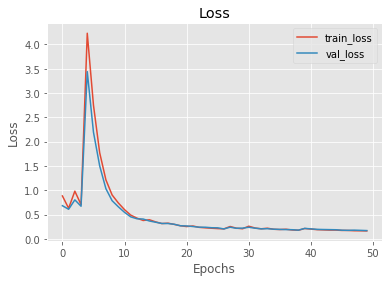

In [0]:
plt.style.use("ggplot")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show();

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

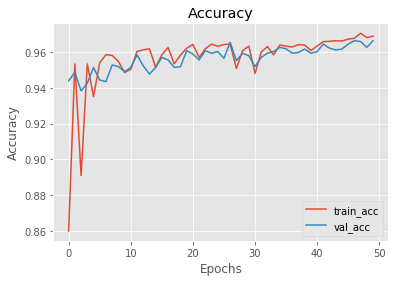

In [0]:
plt.style.use("ggplot")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

In [0]:
H.history["acc"][-1], H.history["val_acc"][-1]

(0.9688542825361512, 0.9663551398526843)

In [0]:
np.sum(list(testGen.classes) == predIdxs) / len(list(testGen.classes))

0.965166908563135

#### Training Accuracy :
             0.968854
             
#### Validation Accuracy:
             0.966355
             
#### Testing Accuracy:
             0.965167